<a href="https://colab.research.google.com/github/gitgabgit/interdune_viz/blob/main/marsrocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross Strata Detectron2 Fast RCNN

Authors: Gabrielle Melli, Andrew Foerder

Date: 3/13/2024

# Purpose

The purpose of this notebook is to train a Detectron2 COCO detection fast rcnn model to recognize Cross-Strata features in ariel images.

# User Settings


In [1]:
# Uncomment the paths underneath your name and comment out the paths underneath
# the other user's name prior to running the notebook

# TODO: After labeling the ponding shorelines, you will have another csv file of
# labels. Create another filepath for the second csv here to use later.

## Andrew paths
#label_path = '/content/gdrive/MyDrive/Andrew/Data Elements/White Sands Labels 03_01_2024.csv'  # path to the original csv file
# gdrive_image_dir = '/content/gdrive/MyDrive/Andrew/Data Elements/Images for ML'  # path to the images directory

# Gabby paths
label_path = '/content/gdrive/MyDrive/Work Stuff/Freelance Work/Andrew/Data Elements/White Sands Labels 03_01_2024.csv'
gdrive_image_dir = '/content/gdrive/MyDrive/Work Stuff/Freelance Work/Andrew/Data Elements/Images for ML'

# Environment Setup

In [2]:
%%capture
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

!python -m pip install split-folders

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Import packages
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import libraries that allow for dataset generation
import splitfolders
from google.colab import drive


# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog



In [5]:
# Connect to user's google drive to access image files and labels
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Split the image folders into 'train' and 'val' folders accessible from this
# working directory rather than directly from Google Drive

splitfolders.ratio(gdrive_image_dir,
                   output="output",
                   seed=1420,
                   ratio=(0.7, 0.3))

Copying files: 435 files [00:14, 29.61 files/s] 


# Data Generation

In [7]:
# Read the label csv into a pandas dataframe. Create a list of the filenames
# of the images that have labels.

# TODO: After labeling the ponding shorelines, you will have another csv file of
# labels. Load them both into dataframes and combine the dataframes using
# concat(). Look up documentation for all necessary parameters.


labels_df = pd.read_csv(label_path)
label_image_file_names = labels_df.image_name.unique()

In [8]:
# Define function to generate detectron2-readable image labels.

# TODO: This will be the bulk of the additional work in setting up the
# second class labels.


def get_xstrata_dicts(image_dir: str, label_image_file_names: list) -> list:
  # initiate an empty list for all of the image dictionaries
  dataset_dicts = []
  # initiate a counter that will act as an indexer for each image
  image_id = 0

  # create a list of the files in the image directory
  image_dir_file_list = os.listdir(image_dir)
  # create a new list that includes only images found both in the directory AND the labeled images
  dict_file_list = list(set(image_dir_file_list) & set(label_image_file_names))

  # iterate over all the images in the above list
  for file_name in dict_file_list:
    # initiate an empty dictionary for each image
    image_dict = {}
    # create a string of the full filepath to the image in the train/val directories
    full_name = os.path.join(image_dir, file_name)
    # insert file name into the dictionary
    image_dict['file_name'] = os.path.join(full_name)
    # insert overall image height into the dictionary
    image_dict['height'] = labels_df.loc[labels_df['image_name']==file_name].iloc[0].image_height
    # insert overall image width into the dictionary
    image_dict['width'] = labels_df.loc[labels_df['image_name']==file_name].iloc[0].image_width
    # use the counter variable to create an image id
    image_dict['image_id'] = image_id


    # TODO: this currently creates a list of dictionaries for each bbox of xstrata in a given image.
    # your task is to add a dictionary for each bbox of ponding shorelines to the same list.

    # initiate an empty list for this image's annotations
    annotations_list = []
    # iterate over every row in the dataframe that has the current image name
    # create a dictionary for each bounding box, and join those in a list to add to the overall image dictionary
    for index, row in labels_df.loc[labels_df['image_name']==file_name].iterrows():
      # initiate empty dictionary
      annotation_dict = {}
      # add the coordinates of the bounding box to the dictionary
      annotation_dict['bbox'] = [row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height]
      # add the type of bounding box to the dictionary
      annotation_dict['bbox_mode'] = BoxMode.XYWH_ABS
      # TODO: below, the category_id is 0 because we only had one class (xstrata).
      # change this to be either 0 or 1 depending on if the label is xstrata or ponding shorelines
      # hint: look into np.where() function
      annotation_dict['category_id'] = 0

      # add this bounding box dictionary to the list of dictionaries for this image
      annotations_list.append(annotation_dict)

    # once all the bounding boxes for this image are generated and listed,
    # insert that list into the overall image dictionary
    image_dict['annotations'] = annotations_list
    # once the image dictionary is complete, add the dictionary to the list of image dictionaries
    dataset_dicts.append(image_dict)
    # increase the counter
    image_id += 1

  # once all the image labels are created, return the list of dictionaries
  return dataset_dicts


In [9]:
# we have 2 datasets, train and validation

# for each of the datasets, register the dataset for the detectron model to reference
for d in ['train', 'val']:
  # register the data set by giving it a name and creating the list of labels we defined above
  DatasetCatalog.register('xstrata_new_' + d, lambda d = d: get_xstrata_dicts('output/' + d + '/Cross-Strata', label_image_file_names))
  # register the metadata
  # TODO: add ponding shorelines to the thing_classes parameter
  MetadataCatalog.get('xstrata_new_' + d).set(thing_classes=['xstrata'])
xstrata_metadata = MetadataCatalog.get('xstrata_train')

In [10]:
# check our work with the training dataset
image_dir = 'output/train/Cross-Strata'
# generate the label dictionaries for the training dataset
dataset_train_dicts = get_xstrata_dicts(image_dir, label_image_file_names)

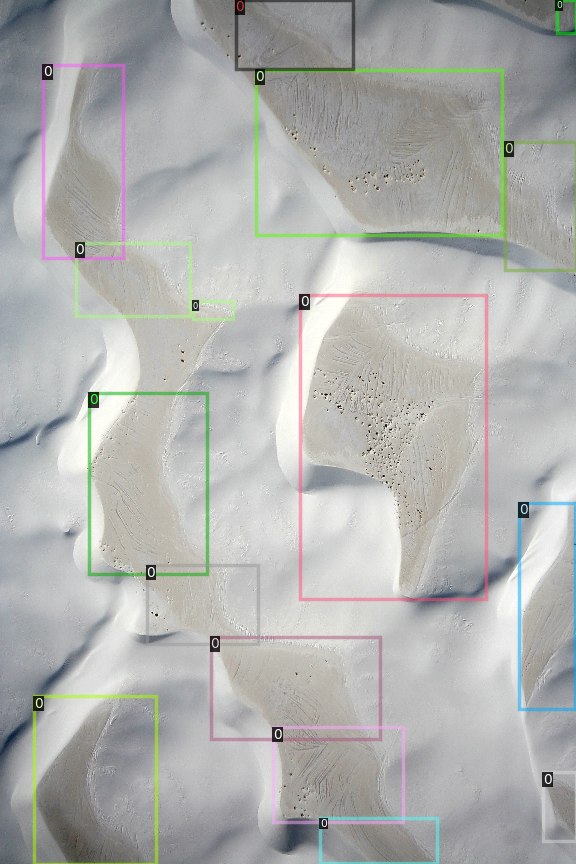

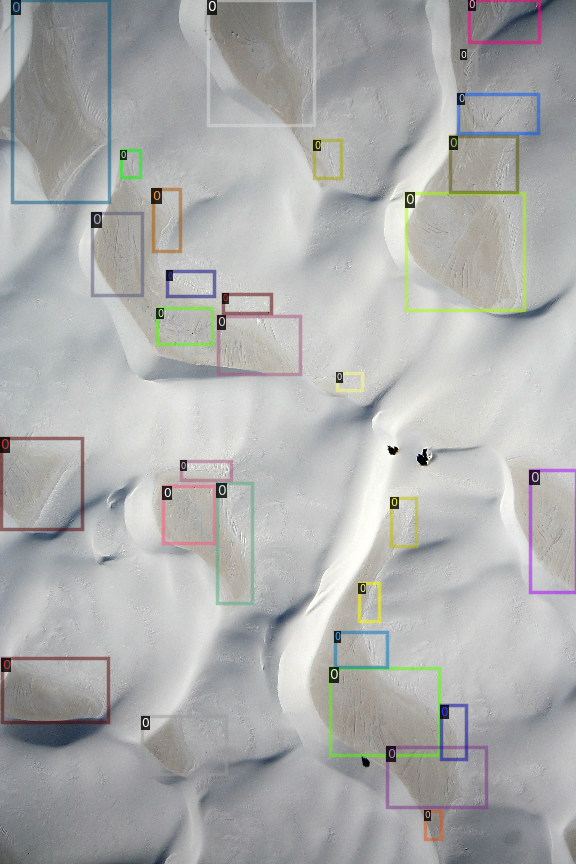

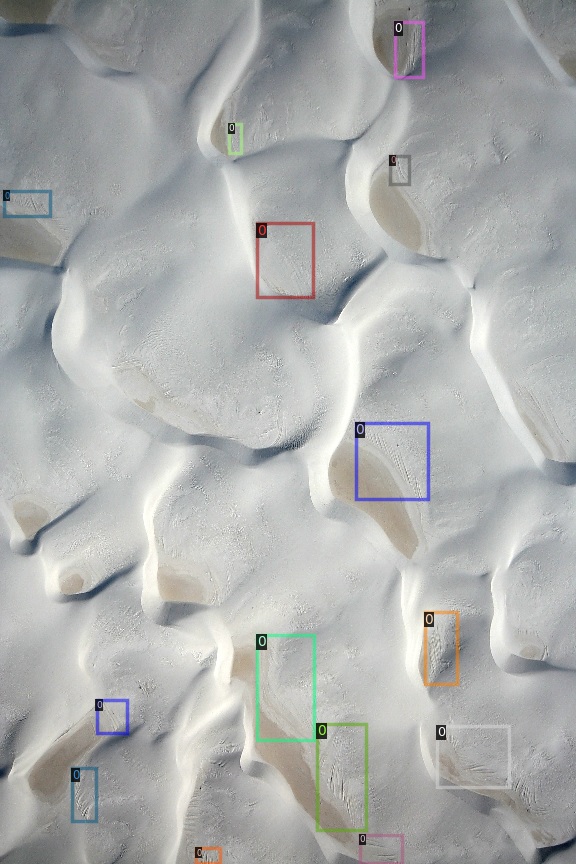

In [11]:
# on 3 random samples from the training dataset, output the image and the labels you created for the image
for d in random.sample(dataset_train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Model Training

In [12]:
# initiate a detectron2 config object
cfg = get_cfg()
# choose a model from the model zoo. faster rcnn will work with bounding box-only labels
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
# define train dataset that we registered earlier
cfg.DATASETS.TRAIN = ("xstrata_new_train",)
# we don't have a test dataset right now, but if we did, we would define it here
cfg.DATASETS.TEST = ()
# a setting for model processing
cfg.DATALOADER.NUM_WORKERS = 2
# gets the model weights from the model file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")

# below are parameters we could change for various experimentation. likely out of scope for abstract.
# comment from detectron2 tutorial: This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.IMS_PER_BATCH = 2
# define learning rate
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# define max iterations
cfg.SOLVER.MAX_ITER = 300    # comment from detectron2 tutorial: 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # comment from detectron2 tutorial: do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # comment from detectron2 tutorial: The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
# TODO: we now have 2 classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # comment from detectron2 tutorial: only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# comment from detectron2 tutorial: NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# creates directories to output results
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# define detectron2 trainer object using the cfg object we defined above
trainer = DefaultTrainer(cfg)
# a setting that I don't know much about
trainer.resume_or_load(resume=False)
# train train train!!
trainer.train()

[03/14 17:44:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_298dad.pkl: 212MB [00:01, 137MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/14 17:44:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/14 17:45:17 d2.utils.events]:  eta: 0:03:24  iter: 19  total_loss: 2.745  loss_cls: 0.7437  loss_box_reg: 0.4071  loss_rpn_cls: 1.256  loss_rpn_loc: 0.1231    time: 0.7440  last_time: 0.8007  data_time: 0.0255  last_data_time: 0.0234   lr: 1.6068e-05  max_mem: 2994M
[03/14 17:45:34 d2.utils.events]:  eta: 0:03:11  iter: 39  total_loss: 2.268  loss_cls: 0.5718  loss_box_reg: 0.5314  loss_rpn_cls: 1.041  loss_rpn_loc: 0.1178    time: 0.7527  last_time: 0.6375  data_time: 0.0161  last_data_time: 0.0061   lr: 3.2718e-05  max_mem: 2997M
[03/14 17:45:50 d2.utils.events]:  eta: 0:02:58  iter: 59  total_loss: 1.853  loss_cls: 0.5457  loss_box_reg: 0.677  loss_rpn_cls: 0.568  loss_rpn_loc: 0.09792    time: 0.7609  last_time: 0.8161  data_time: 0.0103  last_data_time: 0.0038   lr: 4.9367e-05  max_mem: 2997M
[03/14 17:46:06 d2.utils.events]:  eta: 0:02:45  iter: 79  total_loss: 1.728  loss_cls: 0.5445  loss_box_reg: 0.7682  loss_rpn_cls: 0.3402  loss_rpn_loc: 0.0964    time: 0.7644  last_time

# Inference

In [13]:
# comment from detectron2 tutorial: Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

# reset the config model weights parameter to our new output model settings
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a score threshold. If the score is above 0.7, we count it as a 'positive' label
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
# define the prediction object using the new config settings defined above
predictor = DefaultPredictor(cfg)

[03/14 17:49:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


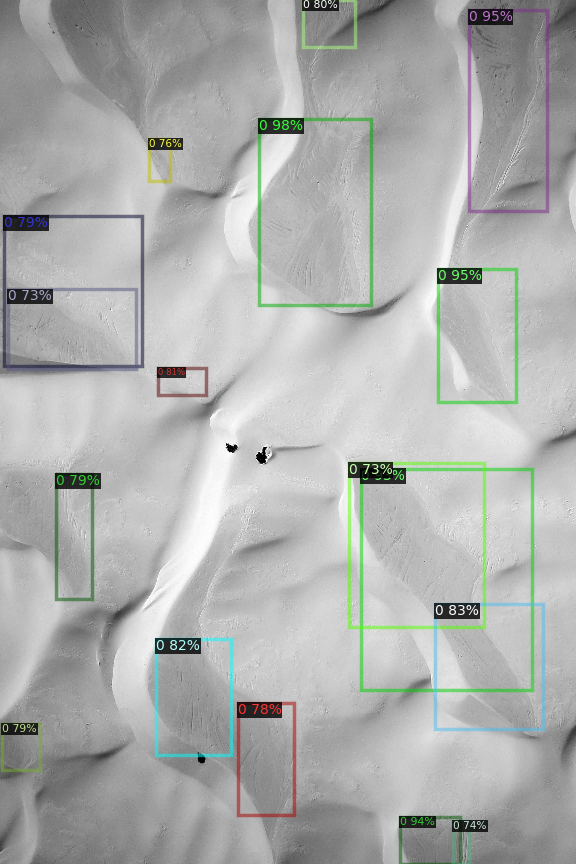

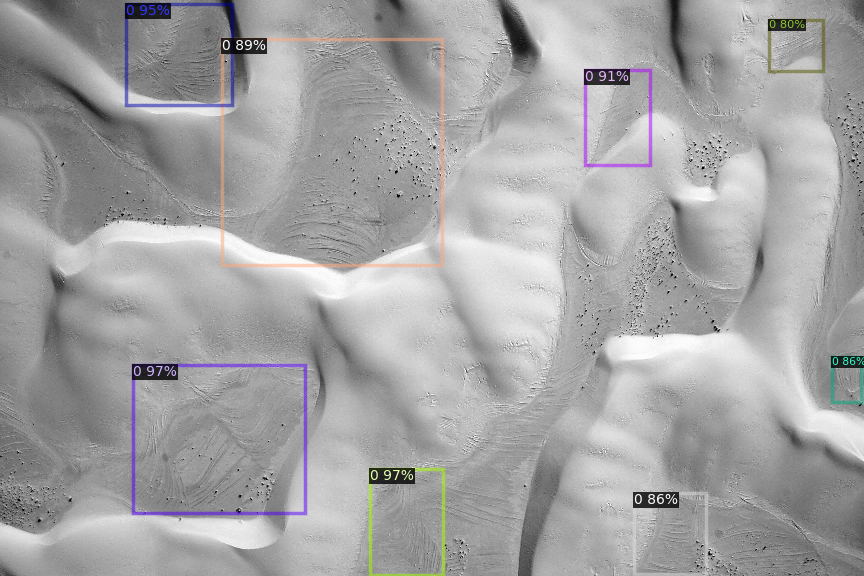

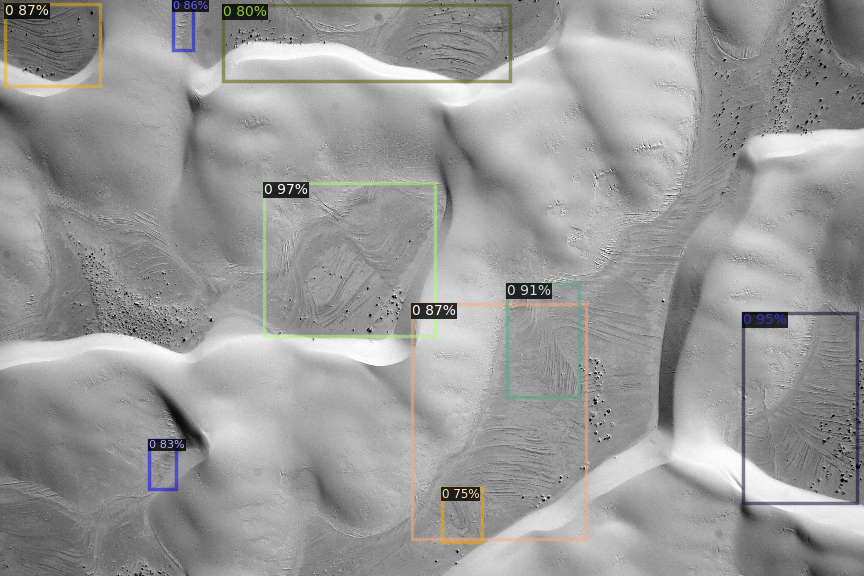

In [14]:
# check our work!
image_dir = 'output/val/Cross-Strata'
# create the image labels for the validation dataset
val_dataset_dicts = get_xstrata_dicts(image_dir, label_image_file_names)

# for 1 random image in the validation dataset, show us the generated labels
for d in random.sample(val_dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=xstrata_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])